# Computer Vision Course Project

## Park Vision


### Setup

In [4]:
%pip install --quiet ultralytics scikit-learn opencv-python tqdm matplotlib pandas kagglehub

Note: you may need to restart the kernel to use updated packages.


In [5]:
import kagglehub
import torch

from ultralytics import YOLO #Handles YOLO class from YOLOV8 Library
from ultralytics.utils.plotting import Annotator #Annotator for bounding boxes and image labels

import cv2 #OpenCV

import os #Operating system (directories/files)
import shutil #High level file operations (ex. copy/delete directories)
import random #Used for randomly splitting or augmenting dataset
import xml.etree.ElementTree as ET #Parse/Manipulate XML files
from sklearn.model_selection import train_test_split #Used to split dataset into training validation and test sets
from tqdm import tqdm #Used to add progress bar to loops

import matplotlib.pyplot as plt #Image, chart plotter
import pandas as pd #Data analysis library

In [7]:
# Check if MPS is available
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

In [ ]:
# # Download latest version
# path = kagglehub.dataset_download("blanderbuss/parking-lot-dataset")

# print("Path to dataset files:", path)

### Test YOLO and annotations are functioning correctly

YOLOv8n summary: 129 layers, 3,157,200 parameters, 0 gradients, 8.9 GFLOPs

image 1/1 /Users/aaron/Library/CloudStorage/OneDrive-Personal/University/Current Semester/Computer Vision - 4220/courseProject/ParkVision/06-object-detection-using-yolo/bus.jpg: 640x480 4 persons, 1 bus, 1 stop sign, 44.1ms
Speed: 4.5ms preprocess, 44.1ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 480)


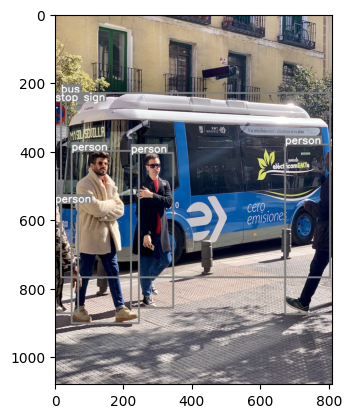

In [8]:
model = YOLO('06-object-detection-using-yolo/yolov8n.pt')
model.info()
results = model('06-object-detection-using-yolo/bus.jpg')


annotator = Annotator(cv2.cvtColor(results[0].orig_img, cv2.COLOR_BGR2RGB))
boxes = results[0].boxes
for box in boxes:
    b = box.xyxy[0]  # get box coordinates in (left, top, right, bottom) format
    c = box.cls
    annotator.box_label(b, model.names[int(c)])

plt.imshow(annotator.result())

### Transform the dataset to be YOLO ready

In [ ]:
#----------------------------------------
# Define class map
#----------------------------------------

class_name_to_id_mapping = {
    "vacant": 0,
    "occupied": 1
}

#----------------------------------------
# Determine Paths
#----------------------------------------

#Original Dataset Location
root_dir = "PKLot"

#New Yolo Ready Dataset
outputDir = "PKLot_YOLORdy"
imagesOutput = os.path.join(outputDir, "images")
labelsOutput = os.path.join(outputDir, "labels")

for sub in ['train', 'val', 'test']:
    os.makedirs(os.path.join(imagesOutput, sub), exist_ok=True) #Path to store images
    os.makedirs(os.path.join(labelsOutput, sub), exist_ok=True) #Path to store YOLO labels


#----------------------------------------
# Parse XML annoatation files
#----------------------------------------

def extract_info_from_xml(xml_path): #Function to extract bounding boxes from XML files
    tree = ET.parse(xml_path)
    root = tree.getroot()

    filename = os.path.splitext(os.path.basename(xml_path))[0] + ".jpg" #Get corresponding image filename
    bboxes = [] #List of bounding boxes for this image

    for space in root.findall("space"): #Loop through each sapce tag in XML (which is a spot)
        
        #Get the occupancy state from XML annoatation
        occupied = space.attrib.get("occupied", "0")
        class_label = "occupied" if occupied == "1" else "vacant"
        class_id = class_name_to_id_mapping[class_label]

        #Read contour and extrac xy
        points = space.find("contour").findall("point")
        x_coords = [int(pt.attrib['x']) for pt in points]
        y_coords = [int(pt.attrib['y']) for pt in points]

        # Convery poly to bounding box
        xmin, xmax = min(x_coords), max(x_coords)
        ymin, ymax = min(y_coords), max(y_coords)

        #append bound box with class ID
        bboxes.append((class_id, xmin, ymin, xmax, ymax))

    return filename, bboxes

#----------------------------------------
# Convert bounding boxes to YOLO format and save as .txt
#----------------------------------------
def convert_to_yolo(filename, bboxes, img_width, img_height, save_path):
    
    lines = []

    for class_id, xmin, ymin, xmax, ymax in bboxes:
        
        #Convert to YOLO format: normalized center_x, center_y, width, height
        x_center = ((xmin + xmax) / 2) / img_width
        y_center = ((ymin + ymax) / 2) / img_height
        width = (xmax - xmin) / img_width
        height = (ymax - ymin) / img_height
        lines.append(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}") #append the completed line

    #write all lines to file
    with open(save_path, "w") as f:
        f.write("\n".join(lines))

# -------------------------------
# Collect image + annotation file pairs
# -------------------------------
image_label_pairs = [] #List to store matched image/XML paths

print("Collecting the files ... ")

#Loop through parking lot dirs
for lot in os.listdir(root_dir):
    lot_path = os.path.join(root_dir, lot)
    if not os.path.isdir(lot_path):
        continue  # skip if not a directory

    # loop through weather conditions (cloudy, rainy, sunny)
    for weather in os.listdir(lot_path): 
        weather_path = os.path.join(lot_path, weather)
        if not os.path.isdir(weather_path):
            continue  # skip if not dir

        #Loop through date folders
        for date_folder in os.listdir(weather_path):
            date_path = os.path.join(weather_path, date_folder)
            if not os.path.isdir(date_path):
                continue #skip non dirs 

            #loop through XML files, and also get matching jpg file
            for file in os.listdir(date_path):
                if file.endswith(".xml"):
                    xml_path = os.path.join(date_path, file)
                    jpg_path = xml_path.replace(".xml", ".jpg")
                    if os.path.exists(jpg_path):
                        image_label_pairs.append((jpg_path, xml_path)) #add to pairs list

#output how many pairs found
print(f"Found {len(image_label_pairs)} annotation image pairs.")

# -------------------------------
# Split into train, val, test
# -------------------------------

train_pairs, test_pairs = train_test_split(image_label_pairs, test_size=0.2, random_state=42)
val_pairs, test_pairs = train_test_split(test_pairs, test_size=0.5, random_state=42)

splits = [("train", train_pairs), ("val", val_pairs), ("test", test_pairs)]

# -------------------------------
# Process and write images + labels
# -------------------------------
print("Process and writing YOLO ready files")

for split_name, pairs in splits:
    for img_path, xml_path in tqdm(pairs, desc=f"Processing {split_name}"):
        try:
            #extract bounding from XML
            filename, bboxes = extract_info_from_xml(xml_path)
            if len(bboxes) == 0:
                continue #skip images with no bounding boxes

            #read image to get width/height
            img = cv2.imread(img_path)
            if img is None:
                continue #skip and unreadble images

            h, w = img.shape[:2]
            label_filename = os.path.splitext(filename)[0] + ".txt"

            # copy image to output folder
            new_img_path = os.path.join(imagesOutput, split_name, filename)
            shutil.copy(img_path, new_img_path)

            # save YOLO label in folder
            new_label_path = os.path.join(labelsOutput, split_name, label_filename)
            convert_to_yolo(filename, bboxes, w, h, new_label_path)
        except Exception as e:
            print(f"Error processing {img_path}: {e}")


# -------------------------------
# Output Completion!
# -------------------------------
print("Dataset formatting complete")

Found 1212 image-annotation pairs.
Processing and writing YOLO files...


Processing test: 100%|███████████████████████████████████████████████████████████████████████████████████| 122/122 [00:00<00:00, 162.65it/s]

Dataset formatting complete


### Test the YOLO ready dataset

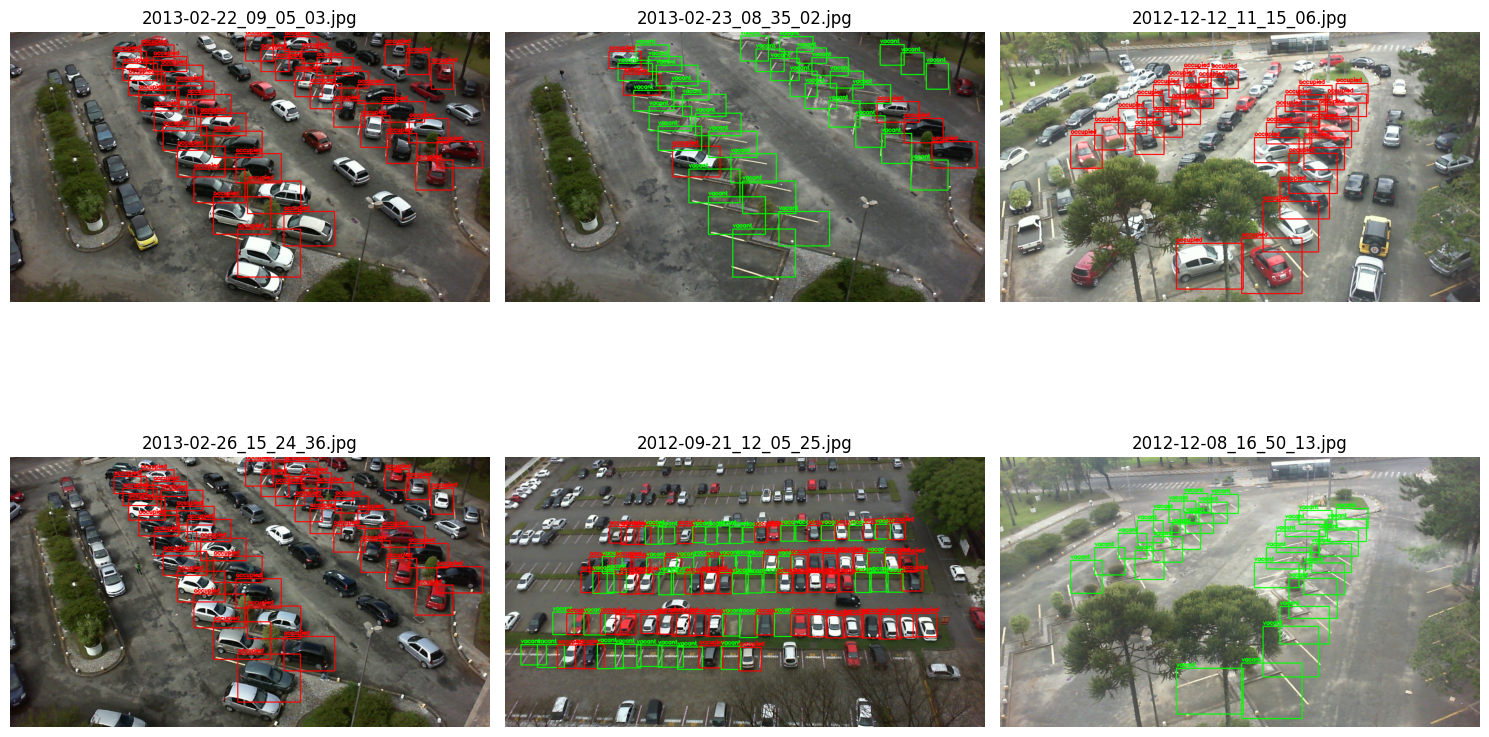

In [16]:
# Set this to your dataset path
images_dir = "PKLot_YOLORdy/images/train"
labels_dir = "PKLot_YOLORdy/labels/train"

class_names = ['vacant', 'occupied']

#Get a set of 6 random images
image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]
sampled_images = random.sample(image_files, 6)

#draw the bounding boxes on the image
def draw_boxes(image_path, label_path):
    img = cv2.imread(image_path)
    h, w = img.shape[:2]
    
    with open(label_path, 'r') as f:
        for line in f:
            class_id, x_center, y_center, box_w, box_h = map(float, line.strip().split())
            x_center *= w
            y_center *= h
            box_w *= w
            box_h *= h

            x1 = int(x_center - box_w / 2)
            y1 = int(y_center - box_h / 2)
            x2 = int(x_center + box_w / 2)
            y2 = int(y_center + box_h / 2)

            class_id = int(class_id)
            color = (0, 255, 0) if class_id == 0 else (0, 0, 255)
            label = class_names[class_id]
            cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
            cv2.putText(img, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Plot the images with thier bound boxes
plt.figure(figsize=(15, 10))
for i, img_file in enumerate(sampled_images):
    img_path = os.path.join(images_dir, img_file)
    label_path = os.path.join(labels_dir, img_file.replace(".jpg", ".txt"))
    img_with_boxes = draw_boxes(img_path, label_path)

    plt.subplot(2, 3, i + 1)
    plt.imshow(img_with_boxes)
    plt.title(img_file)
    plt.axis('off')

plt.tight_layout()
plt.show()